In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

qasm_dir = "/Users/debarthipal/desktop/QASM_circuits_medium"
qasm_files = sorted([
    f for f in os.listdir(qasm_dir)
    if f.endswith(".qasm")
])

In [3]:
from obp_ritajit_2 import perform_obp
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
backend = FakeKolkataV2()

from qiskit_addon_obp.utils.simplify import OperatorBudget

op_budget = OperatorBudget(max_qwc_groups=8)

In [4]:
import json
circ_dic={}
for index, file in enumerate(qasm_files, start=1):
    #print(index)
    n=QuantumCircuit.from_qasm_file(file).num_qubits
    observable_terms = [
            "I"*i + "ZZ" + "I"*(n - i - 2)
            for i in range(n - 1)
        ]
    observable = SparsePauliOp(observable_terms, coeffs=[1/(n - 1)] * (n - 1))
    circuit=QuantumCircuit.from_qasm_file(file)
    depth_transpile_after_bp, depth_transpile_before_bp = perform_obp(circuit, observable, 
                                                                  op_budget, backend)
    circ_dic[index] = {"filename":file, 
                      "depth_transpile_after_bp": depth_transpile_after_bp, 
                      "depth_transpile_before_obp":depth_transpile_before_bp
                      }
    
    json_obj=json.dumps(circ_dic, indent=4)
    with open("depth_qasm_circuits_medium_FakeKolkata_ZZ.json", "w") as f:
        f.write(json_obj)   #Saving to a JSON file

Reached the specified max_seconds timeout!


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_19911/778727955.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(circ_dic).T.fillna(0)


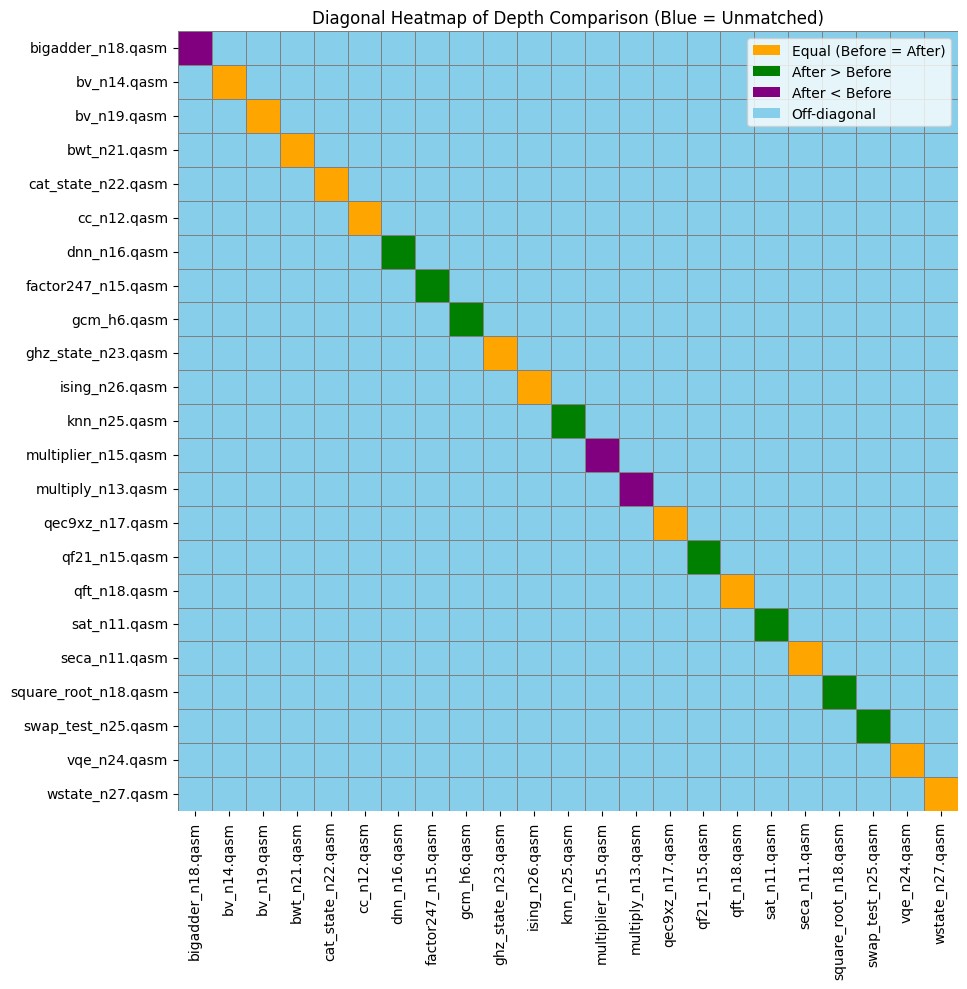

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Custom color map: 0=orange, 1=green, 2=purple, 3=skyblue
colors = ListedColormap(['orange', 'green', 'purple', 'skyblue'])

# Convert dictionary to DataFrame and fill Nones with 0
df = pd.DataFrame(circ_dic).T.fillna(0)

# Extract values
before = df["depth_transpile_before_obp"].to_numpy(dtype=float)
after = df["depth_transpile_after_bp"].to_numpy(dtype=float)
labels = df["filename"].tolist()

# Init matrix with 3 (default color: blue)
matrix = np.full((len(labels), len(labels)), 3)

# Apply logic only to diagonal where filenames match
for i in range(len(labels)):
    if labels[i] == labels[i]:  # always true, but clarifies intent
        if before[i] == after[i]:
            matrix[i, i] = 0  # orange
        elif after[i] > before[i]:
            matrix[i, i] = 1  # green
        else:
            matrix[i, i] = 2  # purple

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap=colors, cbar=False, square=True, linewidths=0.5, linecolor='gray',
            xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title("Diagonal Heatmap of Depth Comparison (Blue = Unmatched)")

# Legend
legend_elements = [
    Patch(facecolor='orange', label='Equal (Before = After)'),
    Patch(facecolor='green', label='After > Before'),
    Patch(facecolor='purple', label='After < Before'),
    Patch(facecolor='skyblue', label='Off-diagonal')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_19911/2137327479.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(circ_dic).T.fillna(0)


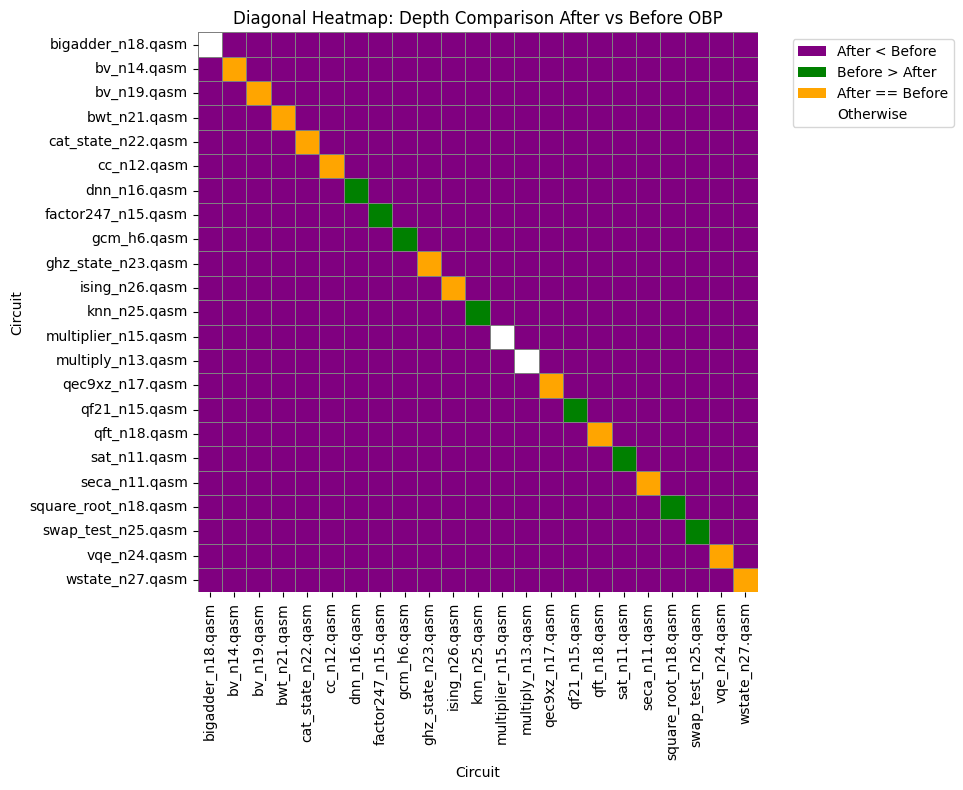

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Custom color map: 0=orange (equal), 1=green (after > before), 2=purple (after < before)
colors = ListedColormap(['purple', 'green', 'orange', 'white'])

# Convert your dictionary to DataFrame and replace None with 0
df = pd.DataFrame(circ_dic).T.fillna(0)

# Extract values
before = df["depth_transpile_before_obp"].to_numpy(dtype=float)
after = df["depth_transpile_after_bp"].to_numpy(dtype=float)

# Initialize square matrix with zeros
matrix = np.zeros((len(before), len(after)))

# Only fill **diagonal** based on comparison
for i in range(len(before)):
    if after[i] < before[i] and after[i]!=0:
        matrix[i, i] = 0 # After < Before -> Purple
    elif after[i] > before[i]:
        matrix[i, i] = 1  # After > Before -> Green
    elif before[i] == after[i]: 
        matrix[i,i] = 2 # Equal -> Orange
    else:
        matrix[i,i] = 3 # White


# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap=colors, cbar=False, square=True, linewidths=0.5, linecolor='gray',
            xticklabels=df["filename"], yticklabels=df["filename"])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Circuit")
plt.ylabel("Circuit")
plt.title("Diagonal Heatmap: Depth Comparison After vs Before OBP")

# Custom legend
legend_elements = [
    Patch(facecolor='purple', label='After < Before'),
    Patch(facecolor='green', label='Before > After'),
    Patch(facecolor='orange', label='After == Before'),
    Patch(facecolor='white', label='Otherwise')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
